In [1]:
# import libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_color_codes("pastel")
sns.set_style("whitegrid")
%matplotlib inline

from pyspark.sql import SparkSession, Window

from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType, FloatType, DecimalType, BooleanType, NumericType, DoubleType, DateType, TimestampType
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import min as Fmin
from pyspark.sql.functions import max as Fmax
from pyspark.sql.functions import avg, col, concat, count, desc, asc, explode, lit, split, stddev, udf, isnan, when, rank, from_unixtime

from pyspark.ml import Pipeline
from pyspark.ml.feature import MinMaxScaler, VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [2]:
import os
import sys
import datetime
import pickle
# import ConfigParser
import json
import random
import datetime
import re
import seaborn as sns
from importlib import reload

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>div.cell.selected {border-left-width: 1px !important;}</style>"))

#Ipython notebook settings
pd.set_option('max_info_columns', 500)
pd.set_option('max_colwidth',50)
pd.set_option('large_repr', 'info')
pd.set_option ('display.notebook_repr_html', True)

pd.set_option('expand_frame_repr', True)
#pd.set_option('display.html.table_schema', True)
pd.set_option('max_info_rows', 500)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 10000)
pd.set_option('display.large_repr', 'truncate')
pd.options.display.float_format = '{:,.2f}'.format

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [3]:
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

# Load Sparkify dataset

In [4]:
# Read in full sparkify dataset
event_data = "data/mini_sparkify_event_data.json"
df = spark.read.json(event_data)

## description of dataset columns

In [5]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
df.limit(5).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.83,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.61,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


# 

## Amount of different users in Dataset

In [7]:
    #.sample(False,0.1,0)
    #.join( df2, on ='userId', how= 'left_outer')
user_count = df.select('userId') \
    .filter(~col('userId').isNull()) \
    .filter(df.userId != "") \
    .dropDuplicates() \
    .orderBy('userId') \
    .count()

In [8]:
HTML("<h2>User Count: {}</h2>".format(user_count))

# 

## Amount of real User data in dataset that can be used

In [9]:
ratio_of_true_data = float( df.filter(~col('userId').isNull()) .filter(df.userId != "").count() )/ df.count()

In [10]:
HTML("<h3>{} %</h3>".format(round(ratio_of_true_data*100,4) ) )

In [11]:
df = df.filter(~col('userId').isNull()) \
       .filter(df.userId != "") 

```
from pyspark.sql.functions import col, when

#sample data
df = sc.parallelize([['abc', '123'],
                     ['efg', '456'],
                     ['', '789']]).toDF(('CustomerRelStatus', 'count'))

#replace empty string with 'null' and then impute missing value, OR directly impute it with '-1000' in 'otherwise' condition
df = df.withColumn("CustomerStatus",
                   when(col('CustomerRelStatus') != '', col('CustomerRelStatus')).otherwise(None)).drop('CustomerRelStatus')
df = df.na.fill({'CustomerStatus': '-1000'})
df.show()
```

# 

# Analize pages in dataset

In [12]:
df.select(col('page')).dropDuplicates().sort(asc("page")).show( truncate = False)

+-------------------------+
|page                     |
+-------------------------+
|About                    |
|Add Friend               |
|Add to Playlist          |
|Cancel                   |
|Cancellation Confirmation|
|Downgrade                |
|Error                    |
|Help                     |
|Home                     |
|Logout                   |
|NextSong                 |
|Roll Advert              |
|Save Settings            |
|Settings                 |
|Submit Downgrade         |
|Submit Upgrade           |
|Thumbs Down              |
|Thumbs Up                |
|Upgrade                  |
+-------------------------+



In [13]:
def missing(df, col):
    """
    A helper function which count how many missing values in a colum of the dataset.
    
    This function is useful because the data can be either three cases below:
    
    1. NaN
    2. Null
    3. "" (empty string)
    """
    return df.filter((isnan(df[col])) | (df[col].isNull()) | (df[col] == ""))

print("[missing values]\n")
for e in df.columns:
    missing_count = missing(df, e).count()
    if missing_count > 0:
        print("{}\t: {}".format(e, missing_count))

[missing values]

artist	: 50046
length	: 50046
song	: 50046


### 
Just because I have removed the missing users values, only these 3 columns have missing values.. we can check if they are really important or we need to remove them from the dataset

In [14]:
missing(df, 'artist').limit(10).show(truncate=True)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|           page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+
|  null|Logged In|    Colin|     M|           54| Freeman|  null| paid|     Bakersfield, CA|   PUT|Add to Playlist|1538173362000|       29|null|   200|1538352905000|Mozilla/5.0 (Wind...|    30|
|  null|Logged In|    Micah|     M|           84|    Long|  null| free|Boston-Cambridge-...|   GET|    Roll Advert|1538331630000|        8|null|   200|1538353150000|"Mozilla/5.0 (Win...|     9|
|  null|Logged In|    Micah|  

# 
Makes sense that when the user is making some of the actions like `Add to Playlist`, `Roll Advert` or `Thumbs Up` among others, there are no Songs playing. so the recorded message log for the user is not linked to any song in particular. I believe we can continue with this as a cleaned data set.
# 

In [15]:
HTML("<h3>Amount of usable dataset: {}</h3>".format(df.count()))

## 

# Explanatory Data Analysis


Detect number columns and category columns.

    num_cols: Number columns (Integer, Long or Double)
    cat_cols: Category columns (String)



In [16]:
numerical_cols = []
categorical_cols = []

for s in df.schema:
    data_type = str(s.dataType)
    if data_type == "StringType":
        categorical_cols.append(s.name)
    
    if data_type == "LongType" or data_type == "DoubleType" or data_type == "IntegerType":
        numerical_cols.append(s.name)



Interesting is to see userId as categorical value, but it is a string number representation. I think it is ok, so we will leave it as is.

In [17]:
HTML('<h3> next... lets analyze the following categorical values and its possible unique choices </h3>'
+ "".join([' <p style="margin-left:100px;margin-bottom:0px;"> {}  </p>  '.format(e) for e in categorical_cols]) )

In [18]:
id_cols = ['userId']
ts_cols = ['ts']
min_cols = id_cols + ['gender', 'level', 'page', 'status']
interesting_cols = ['auth', 'gender', 'level', 'location', 'method', 'page', 'status', 'userAgent']

In [19]:
for e in interesting_cols: 
    HTML ( df.select(e).dropDuplicates().show(truncate=False) )

+---------+
|auth     |
+---------+
|Cancelled|
|Logged In|
+---------+

+------+
|gender|
+------+
|F     |
|M     |
+------+

+-----+
|level|
+-----+
|free |
|paid |
+-----+

+---------------------------------------+
|location                               |
+---------------------------------------+
|Gainesville, FL                        |
|Atlantic City-Hammonton, NJ            |
|Deltona-Daytona Beach-Ormond Beach, FL |
|San Diego-Carlsbad, CA                 |
|Cleveland-Elyria, OH                   |
|Kingsport-Bristol-Bristol, TN-VA       |
|New Haven-Milford, CT                  |
|Birmingham-Hoover, AL                  |
|Corpus Christi, TX                     |
|Dubuque, IA                            |
|Las Vegas-Henderson-Paradise, NV       |
|Indianapolis-Carmel-Anderson, IN       |
|Seattle-Tacoma-Bellevue, WA            |
|Albany, OR                             |
|Winston-Salem, NC                      |
|Bakersfield, CA                        |
|Los Angeles-Long Beach-A

In [20]:
## users connectiing with Windows / Mac or phone / Linux

userAgent_mac = df.filter( col('userAgent').contains('Mac') )
userAgent_win = df.filter( col('userAgent').contains('Win')  )
userAgent_X11 = df.filter( col('userAgent').contains('X11') )
userAgent_empty = df.filter( (col('userAgent').isNull()) | (col('userAgent')=="") )

isClosed = ( userAgent_empty.count() + userAgent_mac.count() + userAgent_win.count() + userAgent_X11.count() ) == df.select('userAgent').count()


In [21]:
HTML('<h3> UserAgent study </h3>  <h4> empty: {:,} mac: {:,} windows: {:,} linux: {:,} </h4><h4>total Count: {:,}</h4> <br/> is closed group?: {} <br/> (Sum of partials is equal to Total Count)'
     .format( userAgent_empty.count() , userAgent_mac.count() , userAgent_win.count() , userAgent_X11.count(), df.select('userAgent').count() , isClosed) 
    )

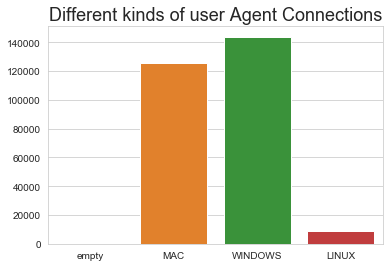

In [22]:
plt.title('Different kinds of user Agent Connections', size= 18)
sns.barplot( ['empty','MAC','WINDOWS','LINUX'] ,
             [userAgent_empty.count(), userAgent_mac.count(), userAgent_win.count(), userAgent_X11.count()])

# 

# Churn detection

In order to detect churn users, we will trigger in the dataset the users that access the `Cancellation Confirmation` page. Just because it is the one the User access when is leaving the paid service.

In [23]:
churn_str = 'Cancellation Confirmation' # 'Cancellation Confirmation' str in page

In [24]:
df.filter( col('page') .contains( churn_str ) ).limit(10).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,None,Cancelled,Adriel,M,104,Mendoza,None,paid,"Kansas City, MO-KS",GET,Cancellation Confirmation,1535623466000,514,None,200,1538943990000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",18
1,None,Cancelled,Diego,M,56,Mckee,None,paid,"Phoenix-Mesa-Scottsdale, AZ",GET,Cancellation Confirmation,1537167593000,540,None,200,1539033046000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",32
2,None,Cancelled,Mason,M,10,Hart,None,free,"Corpus Christi, TX",GET,Cancellation Confirmation,1533157139000,174,None,200,1539318918000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",125
3,None,Cancelled,Alexander,M,332,Garcia,None,paid,"Indianapolis-Carmel-Anderson, IN",GET,Cancellation Confirmation,1536817381000,508,None,200,1539375441000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,105
4,None,Cancelled,Kayla,F,273,Johnson,None,paid,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",GET,Cancellation Confirmation,1538333829000,797,None,200,1539465584000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:24.0) G...,17
5,None,Cancelled,Molly,F,29,Harrison,None,free,"Virginia Beach-Norfolk-Newport News, VA-NC",GET,Cancellation Confirmation,1534255113000,843,None,200,1539588854000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",143
6,None,Cancelled,Alex,M,145,Hogan,None,paid,"Denver-Aurora-Lakewood, CO",GET,Cancellation Confirmation,1535066380000,842,None,200,1539729037000,Mozilla/5.0 (Windows NT 6.2; WOW64; rv:31.0) G...,101
7,None,Cancelled,Davis,M,34,Wang,None,paid,"Flint, MI",GET,Cancellation Confirmation,1538289776000,802,None,200,1539736161000,"""Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebK...",129
8,None,Cancelled,Nikolas,M,287,Olsen,None,paid,"Oxnard-Thousand Oaks-Ventura, CA",GET,Cancellation Confirmation,1528403713000,881,None,200,1539759749000,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:31....,121
9,None,Cancelled,Ethan,M,176,Johnson,None,paid,"Lexington-Fayette, KY",GET,Cancellation Confirmation,1538080987000,934,None,200,1539761972000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",51


In [25]:
def fn_flag_churn(x):
    return 1 if x == churn_str else 0

df_churned = df.withColumn("churned", udf(fn_flag_churn, IntegerType())('page') )


In [26]:
df_churned.limit(1).limit(1).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,churned
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0


In [27]:
df_churned.select(min_cols+['churned']).limit(2).toPandas()

,userId,gender,level,page,status,churned
0,30,M,paid,NextSong,200,0
1,9,M,free,NextSong,200,0


## Calculate churn rate based on `churned` column

In [28]:
(df_churned.groupBy('userId').agg({'churned': 'sum'}) \
              .select('sum(churned)')\
              .count())

225

In [29]:
# (churn users ==1 / Total of those grouped users)
churn_ratio = \
    (df_churned.groupBy('userId').agg({'churned': 'sum'}) \
              .select('sum(churned)')\
              .filter( col('sum(churned)') == 1).count() ) \
    / \
    (df_churned.groupBy('userId').agg({'churned': 'sum'}) \
              .select('sum(churned)')\
              .count())

In [30]:
HTML('<h3>Churn ratio per users in actual dataset</h3><h4>{:.2f} %</h4>'.format(churn_ratio*100))

```
# another way of calculating it is as follows:
churn_ratio = \
    df_churned.groupBy('userId').agg({'churned': 'sum'}) \
          .select(avg('sum(churned)'))\
          .collect()[0][0]
```

In [31]:
windowval = Window.partitionBy("userId").orderBy(asc("ts")).rangeBetween(Window.unboundedPreceding, 0)
df_phase = df_churned.withColumn("phase", Fsum('churned').over(windowval))
df_churn = df_phase.withColumn("churn", Fmax('churned').over(Window.partitionBy("userId")))

In [32]:
df_churn.select(min_cols+["churned", "phase", "churn"]).limit(10).toPandas()

,userId,gender,level,page,status,churned,phase,churn
0,100010,F,free,NextSong,200,0,0,0
1,100010,F,free,NextSong,200,0,0,0
2,100010,F,free,NextSong,200,0,0,0
3,100010,F,free,Thumbs Up,307,0,0,0
4,100010,F,free,NextSong,200,0,0,0
5,100010,F,free,NextSong,200,0,0,0
6,100010,F,free,NextSong,200,0,0,0
7,100010,F,free,NextSong,200,0,0,0
8,100010,F,free,Roll Advert,200,0,0,0
9,100010,F,free,NextSong,200,0,0,0


In [33]:
df_churn.filter(df_churn["churn"] == 1).select(min_cols+["churned", "phase", "churn"]).limit(20).toPandas()

,userId,gender,level,page,status,churned,phase,churn
0,125,M,free,NextSong,200,0,0,1
1,125,M,free,NextSong,200,0,0,1
2,125,M,free,NextSong,200,0,0,1
3,125,M,free,NextSong,200,0,0,1
4,125,M,free,NextSong,200,0,0,1
5,125,M,free,NextSong,200,0,0,1
6,125,M,free,NextSong,200,0,0,1
7,125,M,free,NextSong,200,0,0,1
8,125,M,free,Roll Advert,200,0,0,1
9,125,M,free,Cancel,307,0,1,1


In [34]:
churned_user_count = df_churn.filter(df_churn["churn"] == 1).select("userId").dropDuplicates().count()

In [35]:
HTML("<h4>churned user count: {} (total: {})</h4>".format(churned_user_count, df_churn.select('userId').groupby('userId').agg({'userId':'count'}).count())
    +"<h4>churned user rate: {:.2f}%</h4>".format(churned_user_count / df_churn.select('userId').groupby('userId').agg({'userId':'count'}).count() * 100))

In [36]:
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

# 

# Explore Data

The below columns will be examined:

    .artist
        - the number of artist
    .gender: M or F
    .length
        - the total length
    .level: Free or Paid
    .page
        - the number of Thumbs Up
        - the number of Thumbs Down
    .song
        - the number of song



In [37]:
def fn_churn_label(x):
    return 'Churn' if x == 1 else 'Not Churn'

churn_label_udf = udf(fn_churn_label, StringType())

In [38]:
df_churn_user = df_churn.groupby("userId").max("churn").withColumnRenamed("max(churn)", "churn").select(["userId", "churn"])

### Gender

In [39]:
pd_gender = df_churn.select(["userId", "gender", "churn"]).withColumn("churn", churn_label_udf("churn"))

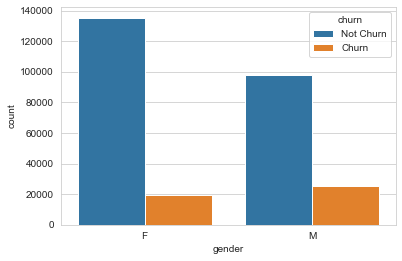

In [40]:
sns.countplot(x="gender", hue="churn", data=pd_gender.toPandas());

### Level

In [41]:
pd_level = df_churn.select(["userId", "level", "churn"]).withColumn("churn", churn_label_udf("churn"))

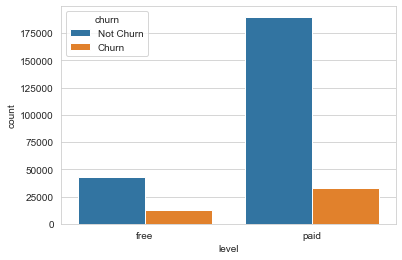

In [42]:
sns.countplot(x="level", hue="churn", data=pd_level.toPandas());

### Artist

In [43]:
pd_artist = df_churn_user.join(df_churn.groupby("userId") \
                                    .agg({"artist": "count"}) \
                                    .withColumnRenamed("count(artist)", "artist_count"), ["userId"]) \
                         .withColumn("churn", churn_label_udf("churn"))

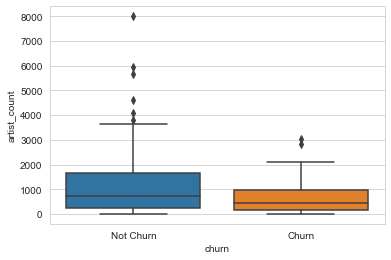

In [44]:
sns.boxplot(x="churn", y="artist_count", data=pd_artist.toPandas());

### Song

In [45]:
pd_song = df_churn_user.join(df_churn.groupby("userId") \
                                     .agg({"song": "count"}) \
                                     .withColumnRenamed("count(song)", "song_count"), ["userId"]) \
                       .withColumn("churn", churn_label_udf("churn"))

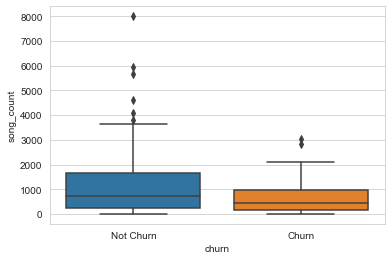

In [46]:
sns.boxplot(x="churn", y="song_count", data=pd_song.toPandas());

### Length

In [47]:
pd_length = df_churn_user.join(df_churn.groupby("userId") \
                                       .agg({"length": "sum"}) \
                                       .withColumnRenamed("sum(length)", "total_length"), ["userId"]) \
                          .withColumn("churn", churn_label_udf("churn"))

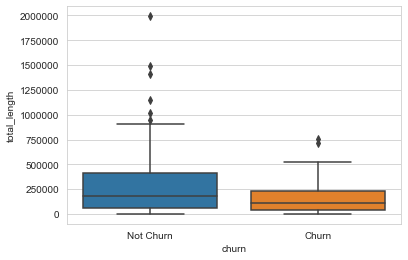

In [48]:
sns.boxplot(x="churn", y="total_length", data=pd_length.toPandas());

### Page visits

In [49]:
pd_visit = df_churn_user.join(df_churn.groupby("userId") \
                                      .count() \
                                      .withColumnRenamed("count", "visit_count"), ["userId"]) \
                         .withColumn("churn", churn_label_udf("churn"))

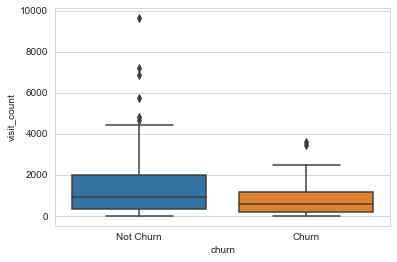

In [50]:
sns.boxplot(x="churn", y="visit_count", data=pd_visit.toPandas());

### Page check Thumbs preferences

In [51]:
pd_up = df_churn_user.join(df_churn.filter((df_churn["page"] == 'Thumbs Up')) \
                                   .groupby("userId") \
                                   .count() \
                                   .withColumnRenamed("count", "up_count"), ["userId"]) \
                     .withColumn("churn", churn_label_udf("churn"))

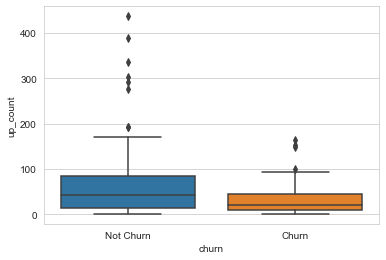

In [52]:
sns.boxplot(x="churn", y="up_count", data=pd_up.toPandas());

In [53]:
pd_down = df_churn_user.join(df_churn.filter((df_churn["page"] == 'Thumbs Down')) \
                                   .groupby("userId") \
                                   .count() \
                                   .withColumnRenamed("count", "down_count"), ["userId"]) \
                     .withColumn("churn", churn_label_udf("churn"))

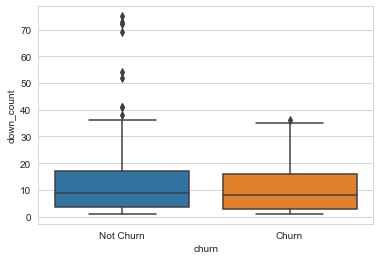

In [54]:
sns.boxplot(x="churn", y="down_count", data=pd_down.toPandas());

# 

# Feauture Engineering


Feature Engineering Ideas

    .artist
        - the number of artist
    .gender: M or F
    .length
        - the total length
    .level: Paid or Free
    .page
        - the number of Thumbs Up
        - the number of Thumbs Down
    .song
        - the number of song



In [67]:
df_master = df_churn.groupby('userId').max("churn").withColumnRenamed("max(churn)", "target")

In [68]:
# artist
user_artist = df_churn.groupby("userId").agg({"artist": "count"}).withColumnRenamed("count(artist)", "artist_count")

# gender
flag_gender = udf(lambda x: 1 if x == "F" else 0, IntegerType())
df_churn_with_gender = df_churn.withColumn("gender", flag_gender("gender"))
user_gender = df_churn_with_gender.groupby('userId').agg({"gender": "max"}).withColumnRenamed("max(gender)", "gender_max")
# length of user
user_length = df_churn.groupby('userId').agg({"length": "sum"}).withColumnRenamed("sum(length)", "length_sum")
# thumbs
user_thumbs_up = df_churn.filter(df_churn["page"] == 'Thumbs Up').groupby('userId').count().withColumnRenamed("count", "thumb_up")
user_thumbs_down = df_churn.filter(df_churn["page"] == 'Thumbs Down').groupby('userId').count().withColumnRenamed("count", "thumb_down")

# level
flag_level = udf(lambda x: 1 if x == "paid" else 0, IntegerType())
df_churn_with_level = df_churn.withColumn("level", flag_level("level"))
user_level = df_churn_with_level.groupby('userId').agg({"level": "max"}).withColumnRenamed("max(level)", "level_max")

# song
user_song = df_churn.groupby("userId").agg({"song": "count"}).withColumnRenamed("count(song)", "song_count")

merged_df = df_master.join(user_artist, ['userId']) \
    .join(user_gender, ['userId']) \
    .join(user_length, ['userId']) \
    .join(user_level, ['userId']) \
    .join(user_thumbs_up, ['userId']) \
    .join(user_thumbs_down, ['userId']) \
    .join(user_song, ['userId'])\
    .dropDuplicates()

# 

# Modeling

In this modeling section, the below tasks will be executed to build models. Three machine learning models will be examined and I will decide one of them based on the evaluation results for further hypyer parameter tuning.

    scaling
    train/test split
    build models
        Logistic Regression
        Random Forest classifier
    evaluate the models based on f1 score since churned users in the dataset are fairly small so the distribution of target variables are extremely biased.


In [71]:
merged = merged_df.drop("userId")\
                  .drop('userAgent')\
                  .drop('firstName')\
                  .drop('lastName')\
                  .drop('method')\
                  .drop('location')\
                  .drop('level')\
                  .drop('ts')\
                  .drop('auth')\
                  .drop('artist')\
                  .drop('song')\
                  .drop('gender')\
                  .drop('page')
merged = merged.fillna(0) # , subset=['a', 'b'])
feature_columns = [e for e in merged.columns if e!='target']
print (feature_columns)
merged.printSchema()

['artist_count', 'gender_max', 'length_sum', 'level_max', 'thumb_up', 'thumb_down', 'song_count']
root
 |-- target: integer (nullable = true)
 |-- artist_count: long (nullable = false)
 |-- gender_max: integer (nullable = true)
 |-- length_sum: double (nullable = false)
 |-- level_max: integer (nullable = true)
 |-- thumb_up: long (nullable = false)
 |-- thumb_down: long (nullable = false)
 |-- song_count: long (nullable = false)



In [72]:
merged.select([count(when(isnan(c), c)).alias(c) for c in merged.columns]).show()

+------+------------+----------+----------+---------+--------+----------+----------+
|target|artist_count|gender_max|length_sum|level_max|thumb_up|thumb_down|song_count|
+------+------------+----------+----------+---------+--------+----------+----------+
|     0|           0|         0|         0|        0|       0|         0|         0|
+------+------------+----------+----------+---------+--------+----------+----------+



In [59]:
pdf = merged.toPandas()

In [60]:
for e in pdf.columns:
    print ('{:30}\t{:8}\t{:30}'.format( e, str(all(pdf[e]=='')), str(pdf[e].dtype )) )

itemInSession                 	False   	int64                         
length                        	False   	float64                       
registration                  	False   	int64                         
sessionId                     	False   	int64                         
status                        	False   	int64                         
artist_count                  	False   	int64                         
gender_max                    	False   	int32                         
length_sum                    	False   	float64                       
level_max                     	False   	int32                         
thumb_up                      	False   	int64                         
thumb_down                    	False   	int64                         
song_count                    	False   	int64                         


In [ ]:
from sklearn.ensemble import  RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import mean_squared_error, mean_absolute_error,explained_variance_score
from sklearn.metrics import accuracy_score,precision_score, recall_score, roc_auc_score

from sklearn.model_selection import train_test_split

from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_predict,cross_val_score

from matplotlib.colors import ListedColormap

from sklearn.svm import SVC

#master0 = pd.get_dummies(master0,columns=['gps_cluster'])

In [ ]:
master, test, y_train, y_test = train_test_split(pdf, label, test_size=0.7, random_state=1306)

In [74]:
train, test = merged.randomSplit([0.7, 0.3], seed=0)

In [62]:
def build_model(classifier, param):
    assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
    scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
    pipeline = Pipeline(stages=[assembler, scaler, classifier])

    model = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=param,
        evaluator=MulticlassClassificationEvaluator(labelCol='target', metricName='f1'),
        numFolds=5,
    )
    return model

## Evaluator design

In [89]:

def evaluate(pred):
    evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="target")
    f1_score = evaluator.evaluate(pred, {evaluator.metricName: "f1"})
    return f1_score


## Logistic Regression (it is not trully a regression! its more classification one!)

In [75]:

lr = LogisticRegression(featuresCol="scaled_features", labelCol="target")
param = ParamGridBuilder().build()
model = build_model(lr, param)


In [80]:
%%time
fit_model = model.fit(train)

Wall time: 18min


In [77]:
pred = fit_model.transform(test)

In [78]:
pred.select("prediction").dropDuplicates().take(10)

[Row(prediction=0.0), Row(prediction=1.0)]

In [90]:
lr_f1_score = evaluate(pred)
print("f1: {}".format(lr_f1_score))

f1: 0.6457586618876942


## RandomForest Classifier

In [81]:

rf = RandomForestClassifier(featuresCol="scaled_features", labelCol="target")
rf_param = ParamGridBuilder().build()
rf_model = build_model(rf, rf_param)


In [82]:
%%time
rf_fit_model = rf_model.fit(train)

Wall time: 7min 53s


In [83]:
rf_pred = rf_fit_model.transform(test)

In [84]:
rf_pred.select("prediction").dropDuplicates().take(10)

[Row(prediction=0.0), Row(prediction=1.0)]

In [91]:
rf_f1_score = evaluate(rf_pred)
print("f1: {}".format(rf_f1_score))

f1: 0.6510545905707196


# f1_score

# Feature Importances

### RandomForest

In [92]:
rf_feature_importance_df = pd.DataFrame()
rf_feature_importance_df['feature'] = feature_columns
rf_feature_importance_df['importance'] = rf_fit_model.bestModel.stages[2].featureImportances.values.tolist()
rf_feature_importance_df = rf_feature_importance_df.sort_values(by='importance', ascending=False).reset_index(drop=True)
rf_feature_importance_df

,feature,importance
0,thumb_down,0.24
1,thumb_up,0.23
2,artist_count,0.21
3,song_count,0.19
4,length_sum,0.10
5,level_max,0.02
6,gender_max,0.01


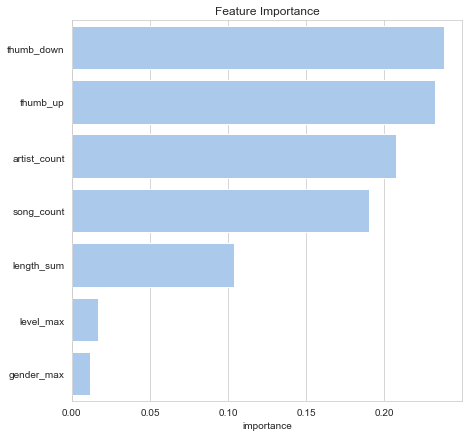

In [93]:
plt.figure(figsize=(7,7))
sns.barplot(x='importance', y='feature', data=rf_feature_importance_df, color="b")
plt.title('Feature Importance')
plt.ylabel('');

### Hyperparameter tunning

In [94]:
classifier = RandomForestClassifier(featuresCol="scaled_features", labelCol="target")

param_grid = ParamGridBuilder() \
    .addGrid(classifier.maxDepth,[5, 10]) \
    .addGrid(classifier.numTrees, [20, 50]) \
    .addGrid(classifier.minInstancesPerNode, [1, 10]) \
    .addGrid(classifier.subsamplingRate, [0.7, 1.0]) \
    .build()

model_tuned = build_model(classifier, param_grid)

In [95]:
%%time
fit_model_tuned = model_tuned.fit(train)

Wall time: 53min 24s


In [96]:
best_model = fit_model_tuned.bestModel
best_model.stages[2].save("random_forest_tuned")

In [97]:
best_model_pred = best_model.transform(test)

In [98]:
best_model_pred.show(5)

+------+------------+----------+------------------+---------+--------+----------+----------+--------------------+--------------------+--------------------+--------------------+----------+
|target|artist_count|gender_max|        length_sum|level_max|thumb_up|thumb_down|song_count|            features|     scaled_features|       rawPrediction|         probability|prediction|
+------+------------+----------+------------------+---------+--------+----------+----------+--------------------+--------------------+--------------------+--------------------+----------+
|     0|         772|         1|      191396.79602|        1|      37|         6|       772|[772.0,1.0,191396...|[0.12217885627015...|[25.7479865592083...|[0.51495973118416...|       0.0|
|     1|        1490|         0|371140.94099999993|        1|      90|        12|      1490|[1490.0,0.0,37114...|[0.24401832682844...|[43.2750348490764...|[0.86550069698152...|       0.0|
|     0|         158|         0|       42228.87856|        0

In [100]:
best_f1_score = evaluate(best_model_pred)
print("f1: {}".format(best_f1_score))

f1: 0.6802567876713543



>The final result is better than the Random Forest model with default parameters. Given that the full dataset (12GB) would provide different results compared with the small subset (128MB), further hyperparameter tuning will be required to gain stable results.


# 

<div style="text-align: right"> 
    Copyright (&copy;) Israel Llorens
    <br/>
    <a href='https://www.linkedin.com/in/israel-llorens-68845438/' target='_blank'> linkedin</a> &nbsp; <a href='https://github.com/sanchezis/' target='_blank'> github </a>
</div>

# 

# 